# Plate2Recipe NLP Model: 
Recipe Generation from Ingredients List using GPT-2 and TF-IDF Similarity Matching

@Author: Nellie Cordova

### NLP Model
- Assume list of ingredients is provided, use this to generate the recipe. 
- Match input list of ingredients with the ingredients in the dataset and generate the recipe
- Approach:
        -- TF-IDF: Vectorization of ingredients.
        -- Cosine Similarity: to find the recipe in the dataset that has the highest similarity to the provided ingredients.
        -- GPT2 model: Generate the recipe based on the matched recipe.

In [ ]:
import sys

print("Python version")
print(sys.version)
print("Version info.")
print(sys.version_info)

In [23]:
import random
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from transformers import GPT2Tokenizer
from transformers import GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import Dataset, DataLoader

!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

### Data Collection and Preprocessing

- Data loading: *use full_dataset.csv for NLP* (https://drive.google.com/drive/folders/1ui_zS11_ENZTCNLUsgg_UwAYr-ZaLbac)
- Data cleaning
- Data augmentation

In [10]:
user_ingredients = ['avocado', 'rice', 'shrimp', 'tomato']
dataset_path = './data/sample.csv'
model_path = './models/nc_model'
best_model_path = './models/best_gpt2_model'
model_logpath = './logs/gpt2_model_log'

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
# Load the dataset
def load_data(filepath):
    return pd.read_csv(filepath).drop(['Unnamed: 0'], axis=1)

recipes = load_data(dataset_path)

,title,ingredients,directions,link,source,NER
0,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
1,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
2,Summer Spaghetti,"[""1 lb. very thin spaghetti"", ""1/2 bottle McCo...","[""Prepare spaghetti per package."", ""Drain."", ""...",www.cookbooks.com/Recipe-Details.aspx?id=841144,Gathered,"[""Salad Supreme"", ""Italian dressing""]"
3,Chicken Stew,"[""3 lb. chicken, boiled"", ""4 medium potatoes, ...","[""Remove chicken from bone."", ""Use the broth.""...",www.cookbooks.com/Recipe-Details.aspx?id=284237,Gathered,"[""chicken"", ""potatoes"", ""onions"", ""corn"", ""Eng..."
4,Ceviche,"[""1 lb. whitefish fillets (raw)"", ""juice of 1 ...","[""Cut uncooked fish into small pieces."", ""Add ...",www.cookbooks.com/Recipe-Details.aspx?id=1920,Gathered,"[""whitefish"", ""lime"", ""tomatoes"", ""green chili..."


In [14]:
# Set a seed for reproducibility
random.seed(42)

# Shuffle the DataFrame
recipes_shuffled = recipes.sample(frac=1).reset_index(drop=True)

# Select 50% of the recipes randomly
num_recipes_to_keep = 500000 #int(len(recipes_shuffled) * 0.5)
recipes = recipes_shuffled[:num_recipes_to_keep]

# Print the new DataFrame
recipes.head(5)

title          0
ingredients    0
directions     0
link           0
source         0
NER            0
dtype: int64


In [13]:
print(recipes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        9 non-null      object
 1   ingredients  9 non-null      object
 2   directions   9 non-null      object
 3   link         9 non-null      object
 4   source       9 non-null      object
 5   NER          9 non-null      object
dtypes: object(6)
memory usage: 560.0+ bytes
None


#### Tokenize, compute TF-IDF and prepare the similarity measure

In [101]:
def load_model(model_path):
    model = GPT2LMHeadModel.from_pretrained(model_path)
    tokenizer = GPT2Tokenizer.from_pretrained(model_path)
    return model, tokenizer

In [102]:
def prepare_similarity_matrix(recipes):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(recipes['NER'])
    return tfidf_vectorizer, tfidf_matrix

tfidf_vectorizer, tfidf_matrix = prepare_similarity_matrix(recipes)

In [103]:
import ast

def find_best_match(user_ingredients, recipes, tfidf_vectorizer, tfidf_matrix):
    """Calculate cosine similarity and return the best recipe match."""
    user_input_tfidf = tfidf_vectorizer.transform([' '.join(user_ingredients)])
    cos_similarities = cosine_similarity(user_input_tfidf, tfidf_matrix)
    best_recipe_index = cos_similarities.argmax()
    return recipes.iloc[best_recipe_index]

def remove_repetitions(text):
    """Helper function to remove repeated sentences in a list of directions."""
    seen = set()
    result = []
    for item in text:
        if item not in seen:
            seen.add(item)
            result.append(item)
    return result

def generate_recipe_text(user_ingredients, recipes, tfidf_vectorizer, tfidf_matrix, model, tokenizer):
    # Find the recipe that matches the user ingredients
    best_recipe = find_best_match(user_ingredients, recipes, tfidf_vectorizer, tfidf_matrix)

    # Parse ingredients and directions from the dataframe
    ingredients_list = ast.literal_eval(best_recipe['ingredients'])
    directions_list = ast.literal_eval(best_recipe['directions'])

    # Reformat input to the model
    ingredients_text = "Ingredients:\n" + "\n".join([f"- {ingredient}" for ingredient in ingredients_list])
    directions_text = "Directions:\n" + "\n".join([f"Step {i+1}: {step}" for i, step in enumerate(directions_list)])
    prompt_text = f"Recipe Title: {best_recipe['title']}\n\n{ingredients_text}\n\n{directions_text}"

    # Generate the recipe text
    encoded = tokenizer.encode_plus(prompt_text, return_tensors="pt", padding='max_length', truncation=True)
    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)
    pad_token_id = tokenizer.pad_token_id
    outputs = model.generate(input_ids, attention_mask=attention_mask, pad_token_id=pad_token_id, max_length=1024, num_return_sequences=1, no_repeat_ngram_size=2)
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Remove repetitions from the directions in the generated text
    final_text_lines = generated_text.split('\n')
    final_text_lines = remove_repetitions(final_text_lines)

    return "\n".join(final_text_lines)

- Prepare data for training the GPT-2 model.
- DataLoader creation for training and validation sets.
- Model Training & Validation methods

In [104]:
class RecipeDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.texts = texts
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoded = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'input_ids': encoded['input_ids'].flatten(),
            'attention_mask': encoded['attention_mask'].flatten(),
            'labels': encoded['input_ids'].flatten()  # Labels for language modeling
        }


def create_data_loaders(recipes, batch_size, tokenizer, max_length):
    # Combine title, ingredients, and directions into a single text input for each recipe
    combined_texts = recipes.apply(lambda row: f"Recipe Title: {row['title']} Ingredients: {row['ingredients']} Directions: {row['directions']}", axis=1)
    
    # Split data into training and validation sets
    train_texts, val_texts = train_test_split(combined_texts, test_size=0.2, random_state=42)

    # Create Dataset objects
    train_dataset = RecipeDataset(train_texts.tolist(), tokenizer, max_length)
    val_dataset = RecipeDataset(val_texts.tolist(), tokenizer, max_length)
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader

### Model Training and Validation

In [105]:
def train_and_validate(model, recipes, tokenizer, device, best_params):
    # Cast batch size and num_train_epochs from best_params
    batch_size = int(best_params.get('batch_size', 8))
    num_train_epochs = int(best_params.get('num_train_epochs', 10))
    learning_rate = best_params.get('learning_rate', 1e-5)
    weight_decay = best_params.get('weight_decay', 0)  # Default to 0 if not specified
    warmup_steps = int(best_params.get('warmup_steps', 0))  # Default to 0 if not specified


    # Create data loaders with the best batch size
    train_loader, val_loader = create_data_loaders(recipes, batch_size, tokenizer, max_length=512)

    # Set up the optimizer and scheduler using the best learning rate
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay, no_deprecation_warning=True)
    total_steps = len(train_loader) * num_train_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

    # Lists to store per-epoch metrics
    training_losses = []
    validation_losses = []
    training_perplexities = []
    validation_perplexities = []

    for epoch in range(num_train_epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            model.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / len(train_loader)
        train_ppl = torch.exp(torch.tensor(avg_train_loss)).item()
        training_losses.append(avg_train_loss)
        training_perplexities.append(train_ppl)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_ppl = torch.exp(torch.tensor(avg_val_loss)).item()
        validation_losses.append(avg_val_loss)
        validation_perplexities.append(val_ppl)

        print(f"Epoch {epoch + 1}/{num_train_epochs} | Train Loss: {avg_train_loss:.3f} | Train PPL: {train_ppl:.3f} | Val Loss: {avg_val_loss:.3f} | Val PPL: {val_ppl:.3f}")

    return training_losses, validation_losses, training_perplexities, validation_perplexities

### Visualizing Results

In [106]:
import matplotlib.pyplot as plt

def plot_validation_curves(training_losses, validation_losses, training_perplexities, validation_perplexities):
    epochs = range(1, len(training_losses) + 1)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, validation_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_perplexities, 'bo-', label='Training Perplexity')
    plt.plot(epochs, validation_perplexities, 'ro-', label='Validation Perplexity')
    plt.title('Training and Validation Perplexity')
    plt.xlabel('Epochs')
    plt.ylabel('Perplexity')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

# Model Setup

### Pre-trained GPT-2 Model

In [107]:
# Load the GPT-2 model and tokenizer
# model = GPT2LMHeadModel.from_pretrained('gpt2')
# tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model, tokenizer = load_model('gpt2')
tokenizer.pad_token = tokenizer.eos_token  # Set padding token as EOS token
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [108]:
batch_size = 8
train_loader, val_loader = create_data_loaders(recipes, batch_size, tokenizer, max_length=512)
params = {}
training_losses, validation_losses, training_perplexities, validation_perplexities = train_and_validate(model, recipes, tokenizer, device, params)

Epoch 1/10 | Train Loss: 8.519 | Train PPL: 5008.445 | Val Loss: 9.123 | Val PPL: 9166.904
Epoch 2/10 | Train Loss: 7.488 | Train PPL: 1787.018 | Val Loss: 7.867 | Val PPL: 2610.239
Epoch 3/10 | Train Loss: 6.311 | Train PPL: 550.632 | Val Loss: 6.710 | Val PPL: 820.532
Epoch 4/10 | Train Loss: 5.549 | Train PPL: 257.033 | Val Loss: 5.941 | Val PPL: 380.501
Epoch 5/10 | Train Loss: 5.076 | Train PPL: 160.077 | Val Loss: 5.437 | Val PPL: 229.695
Epoch 6/10 | Train Loss: 4.567 | Train PPL: 96.265 | Val Loss: 5.044 | Val PPL: 155.096
Epoch 7/10 | Train Loss: 4.142 | Train PPL: 62.937 | Val Loss: 4.725 | Val PPL: 112.750
Epoch 8/10 | Train Loss: 3.874 | Train PPL: 48.128 | Val Loss: 4.478 | Val PPL: 88.057
Epoch 9/10 | Train Loss: 3.714 | Train PPL: 41.018 | Val Loss: 4.309 | Val PPL: 74.385
Epoch 10/10 | Train Loss: 3.575 | Train PPL: 35.699 | Val Loss: 4.223 | Val PPL: 68.264


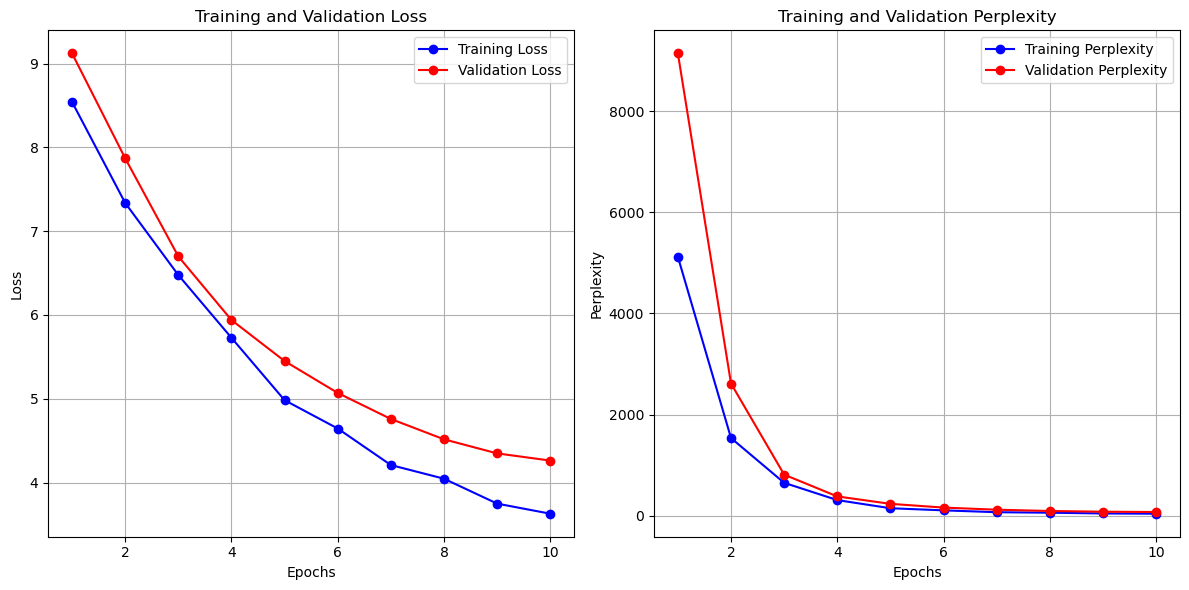

In [95]:
plot_validation_curves(training_losses, validation_losses, training_perplexities, validation_perplexities)

#### Example: Using pretrained GPT-2 with Cosine Similarity for Recipe Generation

In [96]:
recipe_text = generate_recipe_text(user_ingredients, recipes, tfidf_vectorizer, tfidf_matrix, model, tokenizer)
print(recipe_text)

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
/Applications/anaconda3/envs/p2r/lib/python3.8/site-packages/transformers/generation/utils.py:1141: UserWarning: Input length of input_ids is 1024, but `max_length` is set to 1024. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Recipe Title: Ceviche

Ingredients:
- 1 lb. whitefish fillets (raw)
- juice of 1 lime
- 2 medium size tomatoes, peeled
- 2 green chilies, chopped
- 1 small onion, thinly sliced
- 1/4 tsp. oregano
- 3 sprigs cilantro, chopped
- slices of 1 avocado
- wedges of 1 tomato
Directions:
Step 1: Cut uncooked fish into small pieces.
Step 2: Add lime juice to cover fish; cover and refrigerate 3 to 4 hours, or until fish become opaque.
Step 3: Stir occasionally.


## Finding Optimal Model: 
This approach combines traditional NLP techniques for ingredient matching with advanced language generation capabilities of GPT-2

- Prepare data for fine-tuning: tokenize and format the data suitable for GPT-2
- Hyperparameter Tuning: Explore different learning rates, batch sizes, and number of epochs
- Training: Train the model with recipes data, monitoring for convergence and performance.
- Evaluation: Evaluate the model using validation data and metrics like perplexity.
- Visualization of Results: Use plots to show training losses and evaluation metrics.
- Provide Examples of generated recipes vs. actual recipes to visually inspect the quality of generation.

#### Model optimization with Bayesian Optimization 

Bayesian Optimization uses a probabilistic model to guide the search for the best hyperparameters.

### Hyperparameter Tuning

Optimizer Selection
- Adam is a popular choice due to its effectiveness in handling sparse gradients and adaptive learning rate techniques.

Learning Rates
- Initial Value: Starting learning rate in the range of 2e-5 to 5e-5, which are common starting points for fine-tuning language models.
- Decay Strategy: Reduce the learning rate gradually as training progresses. This helps in fine-tuning the model to achieve better performance as it converges.
- Warm-up Steps: Implementing a warm-up period for the learning rate can help stabilize the model's training early in the process, gradually increasing the learning rate from zero to the initial set learning rate.

Batch Sizes
- Size Range: Experiment with batch sizes, starting from smaller batches like 4 or 8, up to larger batches if your hardware supports it (e.g., 16, 32). Larger batch sizes provide a more stable gradient, but they require more memory.
- Gradient Accumulation: If memory limits batch size, use gradient accumulation to simulate larger batches. This means updating model weights less frequently, accumulating gradients over multiple forward passes.

Number of Epochs
- Epoch Count: See how quickly the model learns. Number of epochs is increased based on the initial results and if the model has not started overfitting.
- Early Stopping: Halt training when the validation metric (like perplexity or validation loss) stops improving. This prevents overfitting and saves computational resources.

Weight Decay 
- (L2 Regularization): Prevents overfitting by penalizing large weights. Helps maintain a balance between model complexity and dataset simplicity.

Gradient Clipping: 
- Prevents exploding gradients. By setting a threshold for gradient clipping, you can ensure that gradients exceeding this threshold are scaled down to maintain stability in the training process.

Number of Layers and Hidden Units:
- Adjusting the depth (number of layers) and the width (number of neurons per layer) can impact the learning capabilities and efficiency of the model.
- For transformer models like GPT-2, modifying the number of transformer blocks (layers) and the size of the hidden layers (dimensionality) can influence both performance and training time.


In [97]:
def tune_model(learning_rate, weight_decay, num_train_epochs, warmup_steps, batch_size):
    batch_size = int(batch_size)
    num_train_epochs = int(num_train_epochs)
    warmup_steps = int(warmup_steps)
    
    train_loader, val_loader = create_data_loaders(recipes, batch_size, tokenizer, max_length=512)
    
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay, no_deprecation_warning=True)
    total_steps = len(train_loader) * num_train_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

    model.train()
    min_val_loss = float('inf')
    patience = 0
    patience_limit = 3  # Number of epochs to wait after val loss has stopped improving

    for epoch in range(num_train_epochs):
        total_loss = 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            model.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        # Early stopping logic
        if avg_val_loss < min_val_loss:
            min_val_loss = avg_val_loss
            patience = 0
        else:
            patience += 1
            if patience >= patience_limit:
                print(f"Stopping early at epoch {epoch+1}")
                break

        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.3f}, Val Loss: {avg_val_loss:.3f}")

    return -min_val_loss  # Maximizing the negative loss

In [98]:
# Define parameter bounds
pbounds = {
    'learning_rate': (1e-6, 1e-4),
    'batch_size': (16, 128),
    'num_train_epochs': (1, 10),
    'weight_decay': (1e-4, 1e-2),
    'warmup_steps': (0, 10000),
}

optimizer = BayesianOptimization(
    f=tune_model,
    pbounds=pbounds,
    random_state=1,
)

optimizer.maximize(
    init_points=2,
    n_iter=10,
)

|   iter    |  target   | batch_... | learni... | num_tr... | warmup... | weight... |
-------------------------------------------------------------------------------------


/Applications/anaconda3/envs/p2r/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 1: Train Loss: 3.287, Val Loss: 4.262
| 1         | -4.262    | 62.71     | 7.231e-05 | 1.001     | 3.023e+03 | 0.001553  |
Epoch 1: Train Loss: 3.607, Val Loss: 4.262


KeyboardInterrupt: 

In [84]:
best_params = optimizer.max['params']
print("Best hyperparameters found:")
print(f"- Learning Rate: {best_params['learning_rate']}")
print(f"- Batch Size: {int(best_params['batch_size'])}")
print(f"- Training Epochs: {int(best_params['num_train_epochs'])}")
print(f"- Weight Decay: {best_params['weight_decay']}")
print(f"- Warmup Steps: {int(best_params['warmup_steps'])}")

Best hyperparameters found:
- Learning Rate: 0.00036295900178665746
- Batch Size: 18
- Training Epochs: 2
- Weight Decay: 0.014675589081711305
- Warmup Steps: 151


#### Optimized Model Training and Validation

In [87]:
best_model, tokenizer = load_model(best_model_path)
best_model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [88]:
best_batch_size = int(best_params['batch_size'])
train_loader, val_loader = create_data_loaders(recipes, best_batch_size, tokenizer, max_length=512)

training_losses, validation_losses, training_perplexities, validation_perplexities = train_and_validate(best_model, recipes, tokenizer, device, best_params)

/Applications/anaconda3/envs/p2r/lib/python3.8/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/Applications/anaconda3/envs/p2r/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 1/2 | Train Loss: 0.447 | Train PPL: 1.564 | Val Loss: 0.392 | Val PPL: 1.481
Epoch 2/2 | Train Loss: 0.445 | Train PPL: 1.560 | Val Loss: 0.392 | Val PPL: 1.480


### Visualizing Results

- Training Loss: Plot the training and validation loss over epochs to visualize learning progress and diagnose issues like overfitting or underfitting.
- BLEU Scores or Perplexity Over Time: Similarly, track and plot BLEU scores or perplexity over epochs to assess language model performance improvements.

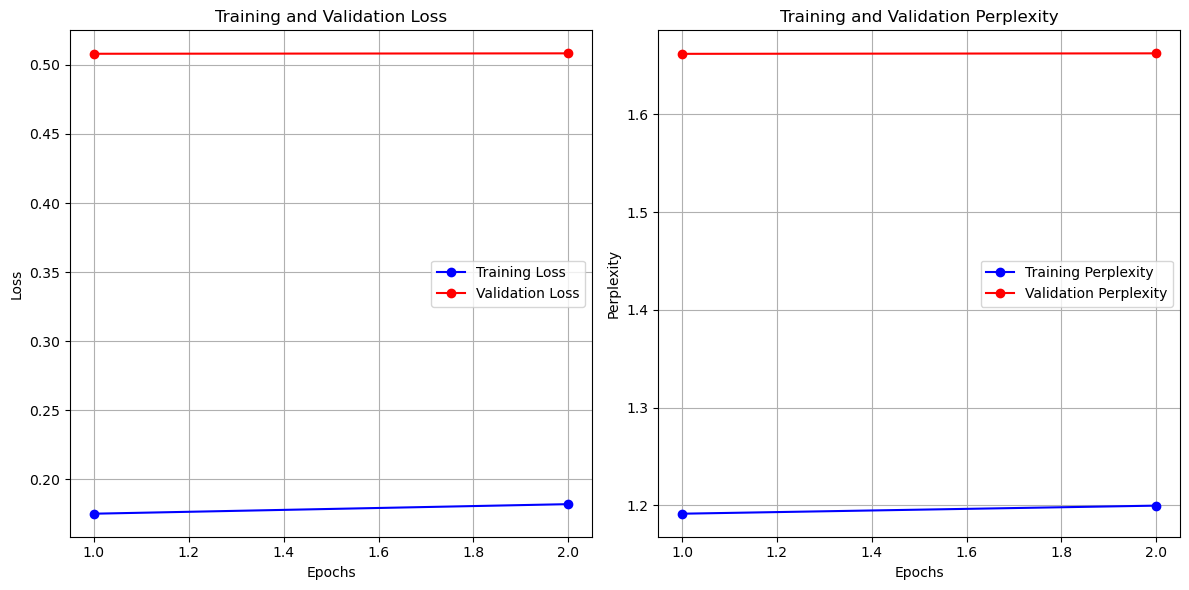

In [71]:
plot_validation_curves(training_losses, validation_losses, training_perplexities, validation_perplexities)

### Example: Generating a Recipe with Optimized model

In [74]:
# Load the best model
best_model, tokenizer = load_model(best_model_path)
tokenizer.pad_token = tokenizer.eos_token
best_model.to(device)

tfidf_vectorizer, tfidf_matrix = prepare_similarity_matrix(recipes)

In [79]:
# Generate the recipe
recipe_text = generate_recipe_text(user_ingredients, recipes, tfidf_vectorizer, tfidf_matrix, best_model, tokenizer)

print(recipe_text)

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
/Applications/anaconda3/envs/p2r/lib/python3.8/site-packages/transformers/generation/utils.py:1141: UserWarning: Input length of input_ids is 1024, but `max_length` is set to 1024. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Recipe Title: Ceviche

Ingredients:
- 1 lb. whitefish fillets (raw)
- juice of 1 lime
- 2 medium size tomatoes, peeled
- 2 green chilies, chopped
- 1 small onion, thinly sliced
- 1/4 tsp. oregano
- 3 sprigs cilantro, chopped
- slices of 1 avocado
- wedges of 1 tomato
Directions:
Step 1: Cut uncooked fish into small pieces.
Step 2: Add lime juice to cover fish; cover and refrigerate 3 to 4 hours, or until fish become opaque.
Step 3: Stir occasionally.
